## Carbon Emissions & Co2 Tax Levels

In [ ]:
## This notebook makes use of OLS Regression and ANOVA Test to investigate the relationship between 
## Co2 Emissions pc and Co2 Tax across a number of countries for which data is available. 

In [91]:
## Load relevant packages  

import os
import sys
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [92]:
## Load datasets

carbon_tax = pd.read_csv('/Users/isabelmartinez/Documents/Projects/ANOVA/Carbon Tax (2023) - carbon_tax_cleaned.csv')

emissions_pc = pd.read_csv('/Users/isabelmartinez/Documents/Projects/ANOVA/CO2 Emissions (2023) - CO2_Emissions_Per_Capita_2023.csv')

In [93]:
## Keep same countries across datasets for consistency

# Merge the DataFrames
merged = pd.merge(emissions_pc, carbon_tax, how='inner', 
                  left_on=['Country'],
                  right_on=['Country'])

merged = merged.drop('Category', axis = 'columns')

merged.head()

,Country,Year,CO2_Emissions_Per_Capita_t,Tax
0,Austria,2023,6.65,35.38
1,Denmark,2023,4.56,26.29
2,Estonia,2023,8.87,2.18
3,Finland,2023,5.73,83.74
4,France,2023,4.25,48.50


In [94]:
# Check for NAn values

merged.isna().sum()

Country                       0
Year                          0
CO2_Emissions_Per_Capita_t    0
Tax                           0
dtype: int64

#### Carbon Tax

In [96]:
merged['Tax'].describe()

count     29.000000
mean      42.634138
std       45.182378
min        0.820000
25%        5.040000
50%       26.290000
75%       53.190000
max      155.870000
Name: Tax, dtype: float64

<Axes: xlabel='Tax', ylabel='Country'>

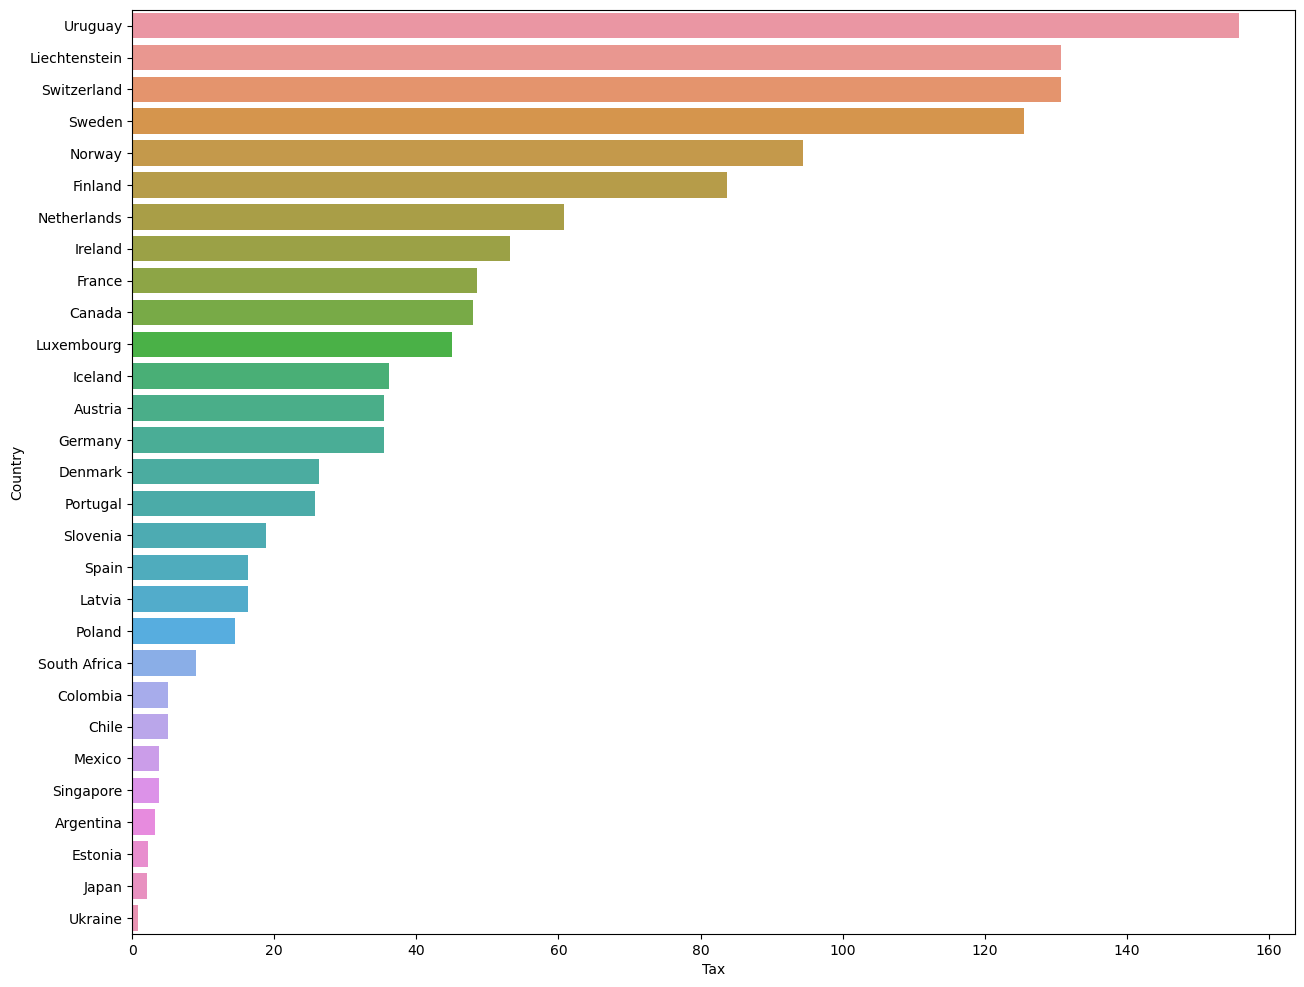

In [97]:
## Visualize Carbon Taxes across countries

fig, ax = plt.subplots(figsize = (15,12))

sns.barplot(data = merged,y = 'Country',x = 'Tax', ax = ax, order = merged.sort_values('Tax', ascending = False).Country)

#### CO2 Emissions pc

In [98]:
merged['CO2_Emissions_Per_Capita_t'].describe()

count    29.000000
mean      5.962069
std       2.861218
min       1.970000
25%       3.870000
50%       5.730000
75%       7.540000
max      14.910000
Name: CO2_Emissions_Per_Capita_t, dtype: float64

<Axes: xlabel='CO2_Emissions_Per_Capita_t', ylabel='Country'>

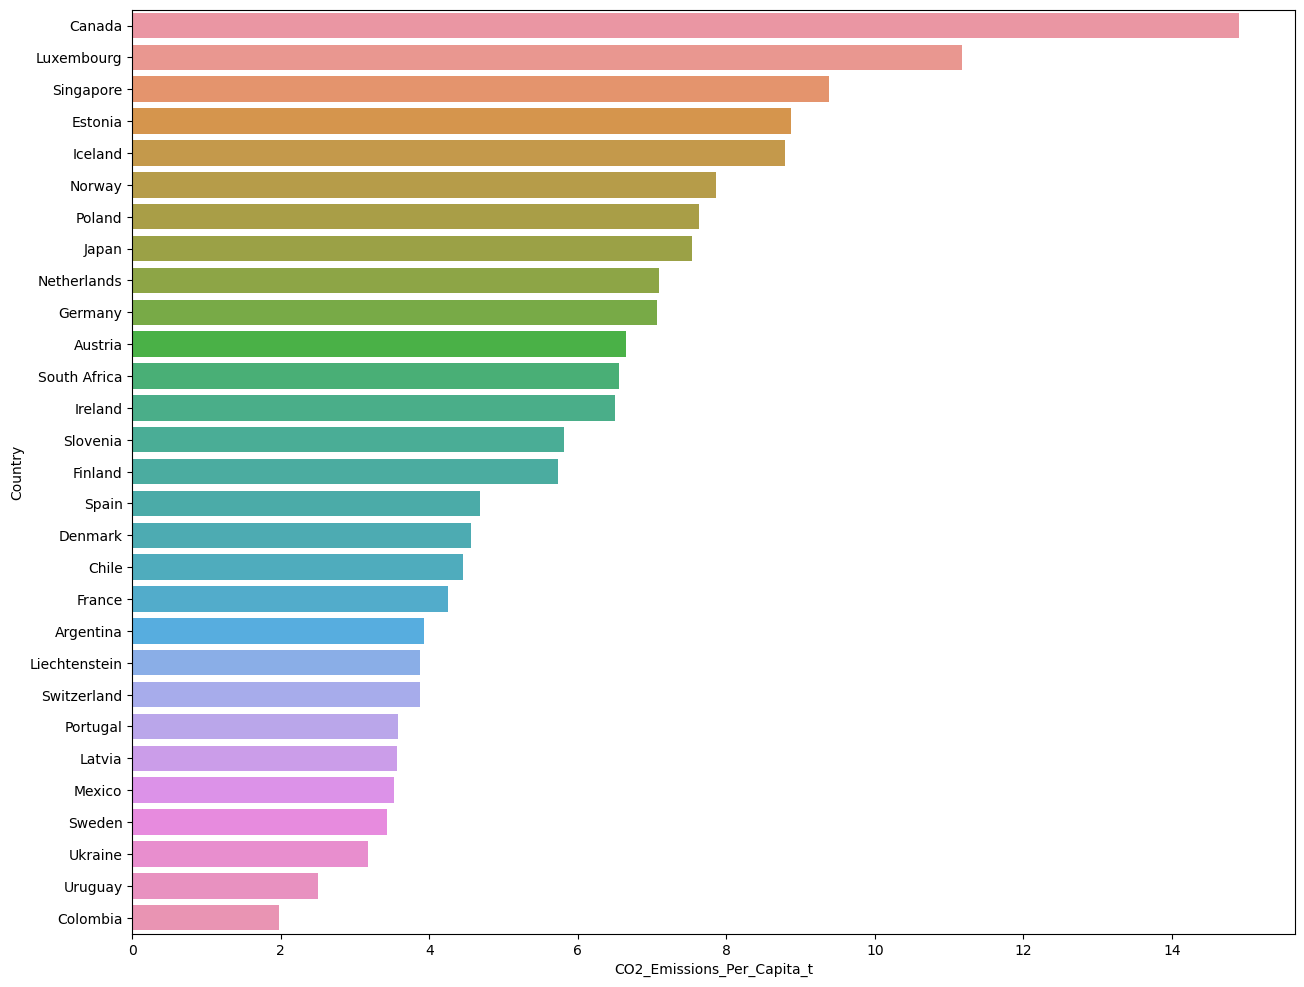

In [99]:
## Visualize Carbon Emissions pc across countries

fig, ax = plt.subplots(figsize = (15,12))

sns.barplot(data = merged,y = 'Country',x = 'CO2_Emissions_Per_Capita_t', ax = ax, order = merged.sort_values('CO2_Emissions_Per_Capita_t', ascending = False).Country)

In [100]:
### Group CO2 Taxes in terms of Tax Levels 
## For this, let's divide the data into quantiles based on imposed Tax

quantiles = np.quantile(merged['Tax'], [0.25, 0.5, 0.75])
quantiles

array([ 5.04, 26.29, 53.19])

In [101]:
## Create Tax Level column based on quantiles

merged['Tax_Level'] = ['Low' if x <= 5.03 else 'Medium' if (x > 5.03) & (x <= 30.835) else 'High' for x in merged['Tax']]

merged.head()

,Country,Year,CO2_Emissions_Per_Capita_t,Tax,Tax_Level
0,Austria,2023,6.65,35.38,High
1,Denmark,2023,4.56,26.29,Medium
2,Estonia,2023,8.87,2.18,Low
3,Finland,2023,5.73,83.74,High
4,France,2023,4.25,48.50,High


### OLS Regression

In [111]:
## Define OLS data, formula and get results 

ols_formula = 'CO2_Emissions_Per_Capita_t ~ C(Tax_Level)'

ols_data = merged[['CO2_Emissions_Per_Capita_t', 'Tax_Level']]

model = ols(formula = ols_formula, data= ols_data).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     CO2_Emissions_Per_Capita_t   R-squared:                       0.081
Model:                                    OLS   Adj. R-squared:                  0.010
Method:                         Least Squares   F-statistic:                     1.141
Date:                        Thu, 21 Aug 2025   Prob (F-statistic):              0.335
Time:                                15:56:34   Log-Likelihood:                -69.907
No. Observations:                          29   AIC:                             145.8
Df Residuals:                              26   BIC:                             149.9
Df Model:                                   2                                         
Covariance Type:                    nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  6.6921      0.761      8.795      0.000       5.128       8.256
C(Tax_Level)[T.Low]       -0.8550      1.318     -0.649      0.522      -3.564       1.854
C(Tax_Level)[T.Medium]    -1.8984      1.262     -1.505      0.144      -4.492       0.695
==============================================================================
Omnibus:                        7.096   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                5.272
Skew:                           0.928   Prob(JB):                       0.0716
Kurtosis:                       3.960   Cond. No.                         3.26
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model Assumptions

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


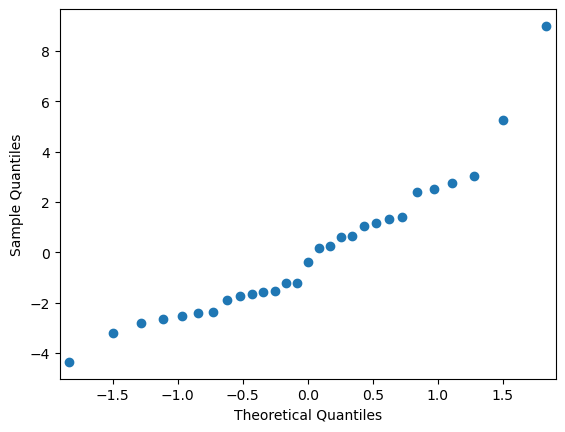

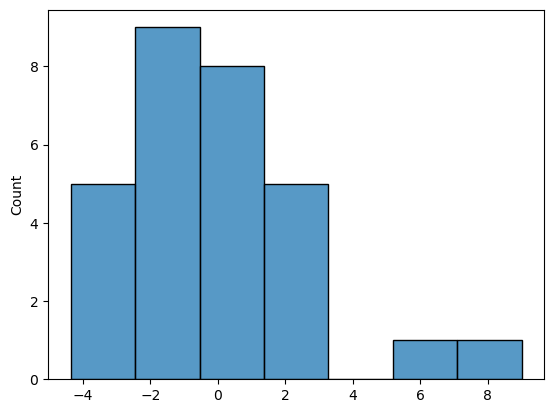

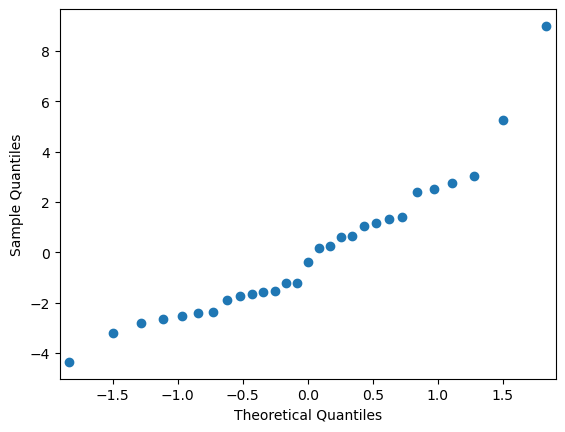

In [107]:
### Residuals are normally distributed 

residuals = model.resid

sns.histplot(data = residuals)

sm.qqplot(data = residuals)

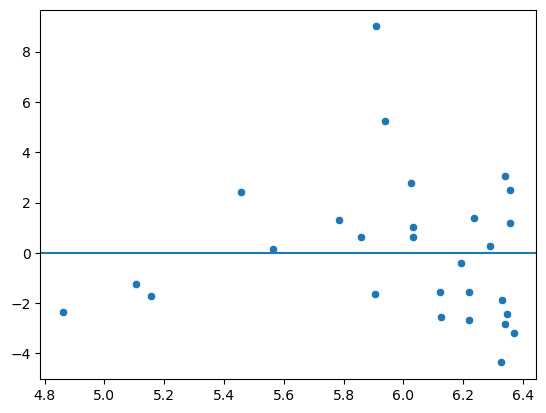

In [109]:
### Homoscedasticity -> constant variance of residuals 

fig = sns.scatterplot(x = model.fittedvalues, y = model.resid)
fig.axhline(0)


### One-way ANOVA Test

In [112]:
## With the model fit, run a one-way ANOVA test to determine whether there is a statistically significant
# difference in Emissions among Tax groups. 

sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Tax_Level),18.491110,2.0,1.140707,0.335073
Residual,210.732766,26.0,NaN,NaN


### ANOVA post hoc test

In [114]:
## Run the Tukey’s HSD post hoc test to compare if there is a significant difference between each pair of categories for Co2 Taxes.

tukey_oneway = pairwise_tukeyhsd(endog = merged["CO2_Emissions_Per_Capita_t"], groups = merged["Tax_Level"])

tukey_oneway.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
High,Low,-0.855,0.7947,-4.1298,2.4198,False
High,Medium,-1.8984,0.3053,-5.0338,1.237,False
Low,Medium,-1.0434,0.7609,-4.7047,2.6179,False
